In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.linear_model import SGDClassifier
from sklearn import svm
import random

file_path = 'train.csv'
data = pd.read_csv(file_path)
#file_path_test = 'C:/Users/Otman/Desktop/OTMAN/Python_Data_Science/KAGGLE_PROJECT/PROJECT00. Titanic/test.csv'
#X_test = pd.read_csv(file_path_test)
y = data.Survived

data = data.drop('Survived',1)
data = data.drop('Name',1)
#data = data.drop('Ticket',1)
data = data.drop('Cabin',1)

X_train,X_test,Y_train,Y_test=train_test_split(data,y,test_size=0.3,random_state=random.seed())

#titanic_model = ExtraTreesRegressor(n_estimators=10, random_state=0)
titanic_model = RandomForestClassifier(n_estimators=1000, max_depth=3,random_state=0)
#titanic_model = SGDClassifier(loss="hinge", penalty="l2", max_iter=5)


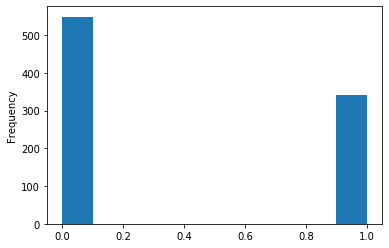

In [18]:
y.plot.hist()

## preparing data for submition

In [27]:
file_path_train = 'train.csv'
Data_train = pd.read_csv(file_path)
Y_train = Data_train.Survived
X_train = Data_train.drop('Survived',1)

file_path_test = 'test.csv'
X_test = pd.read_csv(file_path_test)

X_train = X_train.drop('Name',1)
X_train = X_train.drop('Ticket',1)
X_train = X_train.drop('Cabin',1)
X_test = X_test.drop('Name',1)
X_test = X_test.drop('Ticket',1)
X_test = X_test.drop('Cabin',1)


## remplace the missing values

* remplace the missing value with the firs of any column

In [24]:
train_mode = X_train.mode().iloc[0]
X_train = X_train.fillna(train_mode)
X_test = X_test.fillna(train_mode)

In [28]:
id = X_test.PassengerId.values
X_train.info()
X_train.head()
X_train = X_train.drop('PassengerId',1)
X_test = X_test.drop('PassengerId',1)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 8 columns):
PassengerId    891 non-null int64
Pclass         891 non-null int64
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Fare           891 non-null float64
Embarked       889 non-null object
dtypes: float64(2), int64(4), object(2)
memory usage: 55.8+ KB


* remplace the missing valus with the means of ech columns

In [29]:
from sklearn.impute import SimpleImputer

X_train["Age"].fillna(X_train.Age.mean(), inplace = True) 

# Imputation
my_imputer = SimpleImputer(strategy='most_frequent')
imputed_X_train = pd.DataFrame(my_imputer.fit_transform(X_train))
imputed_X_test = pd.DataFrame(my_imputer.transform(X_test))

# Imputation removed column names; put them back
imputed_X_train.columns = X_train.columns
imputed_X_test.columns = X_test.columns

X_train = imputed_X_train
X_test = imputed_X_test

## serch for the categorical columns and remplace it with numerical value

In [30]:
from sklearn.preprocessing import LabelEncoder

# Get list of categorical variables
s = (X_train.dtypes == 'object')
object_cols = list(s[s].index)

# Make copy to avoid changing original data 
label_X_train = X_train.copy()
label_X_valid = X_test.copy()


# Apply label encoder to each column with categorical data
label_encoder = LabelEncoder()
for col in object_cols:
    X_train[col] = label_encoder.fit_transform(X_train[col])
    X_test[col] = label_encoder.fit_transform(X_test[col])

In [259]:
from sklearn.preprocessing import OneHotEncoder

# Apply one-hot encoder to each column with categorical data
OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
OH_cols_train = pd.DataFrame(OH_encoder.fit_transform(X_train[object_cols]))
OH_cols_valid = pd.DataFrame(OH_encoder.transform(X_test[object_cols]))

# One-hot encoding removed index; put it back
OH_cols_train.index = X_train.index
OH_cols_valid.index = X_test.index

# Remove categorical columns (will replace with one-hot encoding)
num_X_train = X_train.drop(object_cols, axis=1)
num_X_valid = X_test.drop(object_cols, axis=1)

# Add one-hot encoded columns to numerical features
X_train = pd.concat([num_X_train, OH_cols_train], axis=1)
X_test = pd.concat([num_X_valid, OH_cols_valid], axis=1)

In [31]:
#imputed_X_train.head(100)
#X_test.isna().any()
X_train

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,2,1,28,1,0,18,2
1,0,0,52,1,0,207,0
2,2,0,34,0,0,41,2
3,0,0,48,1,0,189,2
4,2,1,48,0,0,43,2
...,...,...,...,...,...,...,...
886,1,1,35,0,0,85,2
887,0,0,24,0,0,153,2
888,2,0,39,1,2,131,2
889,0,1,34,0,0,153,0


## add two columns to one and delete them

In [34]:
X_train['relatives'] = X_train['SibSp'] + X_train['Parch']
X_train = X_train.drop('SibSp',1)
X_train = X_train.drop('Parch',1)

X_test['relatives'] = X_test['SibSp'] + X_test['Parch']
X_test = X_test.drop('SibSp',1)
X_test = X_test.drop('Parch',1)


## test with XGBoost model

In [35]:
from xgboost import XGBClassifier

titanic_model = XGBClassifier()
titanic_model = XGBClassifier(n_estimators=1000, learning_rate=0.05)
titanic_model.fit(X_train, Y_train, 
             early_stopping_rounds=5, 
             eval_set=[(X_train, Y_train)],
             verbose=False)
#titanic_model.score(X_test,Y_test)
Y_predi =  titanic_model.predict(X_test)
submission = pd.DataFrame({ 'PassengerId': id, 'Survived': Y_predi })
submission.to_csv("titanic_submition04_XGBoost.csv", index=False)

In [33]:
titanic_model = RandomForestClassifier(n_estimators=1000, max_depth=3,random_state=0)

titanic_model.fit(X_train, Y_train)
Y_predi =  titanic_model.predict(X_test)

#titanic_model.score(X_test,Y_test)
submission = pd.DataFrame({ 'PassengerId': id, 'Survived': Y_predi })
submission.to_csv("titanic_submition04.csv", index=False)

In [26]:
from sklearn.metrics import mean_absolute_error

predictions = titanic_model.predict(X_test)
print("Mean Absolute Error: " + str(mean_absolute_error(predictions, Y_test)))
print(predictions)
print(Y_test)

Mean Absolute Error: 0.1865671641791045
[1 1 0 1 0 1 1 0 0 0 0 0 0 1 1 0 1 1 0 0 0 0 1 0 0 0 0 0 1 0 0 0 1 1 0 0 1
 1 1 1 1 0 0 1 0 0 0 1 0 1 0 0 1 0 1 0 0 0 1 0 1 0 0 0 0 0 1 1 0 0 0 0 0 0
 0 1 0 1 0 0 1 0 1 0 0 0 0 1 0 1 1 0 0 0 0 0 0 1 0 1 0 0 0 0 0 1 0 0 0 1 0
 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 1 1 0 0 0 0 1 0 0 0
 1 0 0 0 1 0 0 1 1 0 0 0 0 0 1 1 1 0 1 0 0 1 0 0 1 0 0 1 1 0 0 1 0 0 0 1 0
 0 0 0 0 1 1 1 1 1 0 0 1 0 0 1 0 0 1 0 0 1 1 0 0 0 0 0 0 1 0 1 0 0 0 1 1 0
 0 0 1 0 0 0 0 0 1 1 0 1 1 1 0 0 0 1 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 1 1 0 0 1 0 0 0]
887    1
303    1
176    0
387    1
108    0
      ..
138    0
366    1
343    0
672    0
46     0
Name: Survived, Length: 268, dtype: int64


In [59]:
file_path = 'test.csv'
data = pd.read_csv(file_path)

data = data.fillna(train_mode)


# Make copy to avoid changing original data 
data_sub = data.copy()


# Apply label encoder to each column with categorical data
label_encoder = LabelEncoder()
for col in object_cols:
    data_sub[col] = label_encoder.fit_transform(data[col])  
    
data_sub = pd.DataFrame(my_imputer.fit_transform(data_sub))

sub = titanic_model.predict(data_sub)
submission = pd.DataFrame({ 'PassengerId': data.PassengerId.values, 'Survived': sub })
submission.to_csv("C:/Users/Otman/Desktop/titanic_submition.csv", index=False)

# #code test o_O

In [ ]:
print(X_train.head())

In [50]:
imputed_X_valid.shape

(268, 12)

In [ ]:
Y_predi

In [ ]:
data.tail()
dataa.info()

C:\Users\Otman\Anaconda3\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


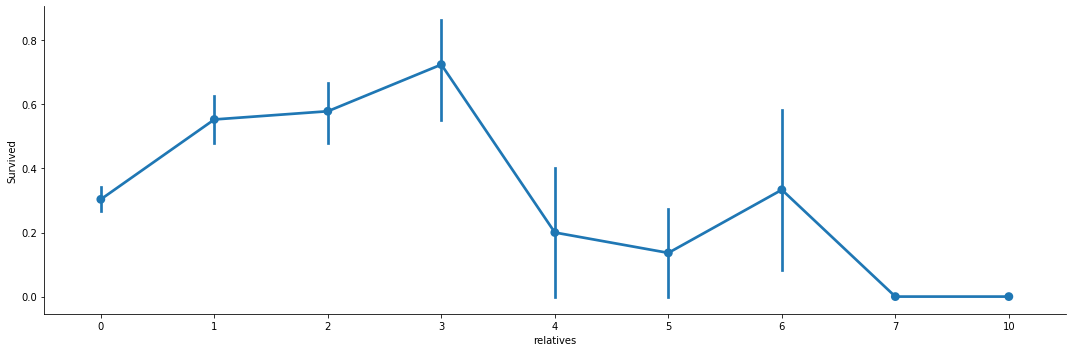

In [255]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
file_path = 'train.csv'
data = pd.read_csv(file_path)
data['relatives'] = data['SibSp'] + data['Parch']
axes = sns.factorplot('relatives','Survived', 
                      data=data, aspect = 3)